# Inference on custom data
Last checked and validated with `fastMONAI` version `0.3.6`

[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/fastMONAI/blob/master/research/endometrial_cancer/02-ec-inference.ipynb)

In [ ]:
#| hide
#Install `fastMONAI` if notebook is running on Google Colab
try:
    import google.colab
    %pip install fastMONAI
    from fastMONAI.utils import print_colab_gpu_info
    print_colab_gpu_info()
except:
    print('Running locally')

In [ ]:
from fastMONAI.vision_all import *
from huggingface_hub import snapshot_download

In [ ]:
# Download the model from the study repository and load the exported learner. 
#By default, the latest version from the main branch is downloaded.
models_path = Path(snapshot_download(repo_id="skaliy/endometrial_cancer_segmentation",  cache_dir='models', revision='main'))

In [ ]:
#Download example data
DATA_DIR = Path('../../data/ec')
download_example_endometrial_cancer_data(path=DATA_DIR, multi_channel=False)

In [ ]:
learner = load_learner(models_path/'vibe-learner.pkl', cpu=True)

In [ ]:
# Load variables
vars_fn = models_path/'vars.pkl'
_, reorder, resample = load_variables(pkl_fn=vars_fn)
reorder, resample

In [ ]:
# Define your path
img_path = DATA_DIR/'vibe.nii.gz'
save_path = str(img_path).replace(img_path.stem, 'pred_' + img_path.stem)

In [ ]:
#pred_items
org_img, input_img, org_size = med_img_reader(img_path, reorder=reorder, resample=resample, only_tensor=False)

mask_data = inference(learner, reorder=reorder, resample=resample, org_img=org_img, input_img=input_img, org_size=org_size).data 

if "".join(org_img.orientation) == 'LSA':        
    mask_data = mask_data.permute(0,1,3,2)
    mask_data = torch.flip(mask_data[0], dims=[1])
    mask_data = torch.Tensor(mask_data)[None]
    
org_img.set_data(mask_data)
org_img.save(save_path)

In [ ]:
from torchio import Subject, ScalarImage, LabelMap

In [ ]:
subject = Subject(image=ScalarImage(img_path), mask=LabelMap(save_path))

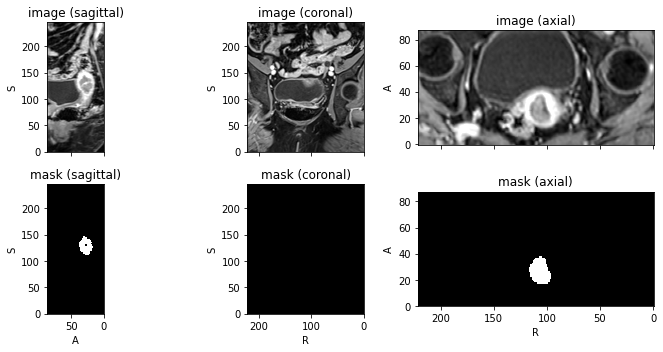

In [ ]:
subject.plot(figsize=(10,5))